一、Django Form
==============
Django form 是個方便的功能，可以做出一個 form 物件傳給 template render，這樣子表單欄位就可以集中化管理(EX: 假設我們要在表單上新增一個欄位，我們需要改 html 的表單與程式碼接表單資料兩部分，而有了 django form 後只需要改 form 物件本身即可)

最常用的 Form:
* forms.Form (基本)
* forms.ModelForm (最常用，用於 Model create 與 update)

我們先來做個新增 Article 的頁面

詳情請參考並試試看: 
* https://docs.djangoproject.com/en/2.2/topics/forms/
* https://docs.djangoproject.com/en/2.2/topics/forms/modelforms/

In [ ]:
# blog/models.py
class Article(models.Model):
    title = models.CharField(max_length=200)
    createTime = models.DateTimeField(auto_now_add=True)
    author = models.ForeignKey(
        User,
        on_delete=models.CASCADE,
    )
    content = models.TextField()
    
# blog/forms.py (沒有的話自己新增)
from django import forms

from blog.models import Article


class ArticleForm(forms.ModelForm):

    class Meta:
        model = Article  # 這個 form 指定給 Article 這個 model 用
        fields = ['title', 'content'] # 在表單上只做出 Article 的兩個欄位
        labels = {
            'title': "標題",
            'content': "內文",
        }
        
# blog/views.py
from blog.forms import ArticleForm

def createArticle(request):
    context = {}
    if request.POST:
        form = ArticleForm(request.POST)
        if form.is_valid():
            # 表單符合規則
            # 用 POST 的資料做成一個 article 物件(相當於 Article.objects.create)
            # commit=False 表示先別直接紀錄到 db，因為我們還要加其他資料
            article = form.save(commit=False) 
            article.author = request.user # 紀錄是誰 create 這個 article 的
            article.save() # 紀錄到 db 去

            context['msg'] = "成功新增一篇文章"
        else:
            # 表單不符合規則
            context['msg'] = "表單錯誤"
    else:
        form = ArticleForm()

    context['form'] = form
        
    return render(request, 'blog/article-add.html', context)

# urls.py
path('article/add/', blog_views.createArticle, name="article-add"),


然後
* python manage.py makemigrations
* python manage.py migrate

再來修改 html
blog/nav_accounts.html

In [ ]:
{% load i18n %}

<nav class="navbar navbar-expand-lg navbar-light bg-light">
  <div class="collapse navbar-collapse" id="navbarSupportedContent">
    <ul class="navbar-nav mr-auto">
      <li class="nav-item">
        <a class="nav-link" href="#">文章清單</a>
      </li>
      {% if request.user.is_authenticated %}
      <li class="nav-item">
        <a class="nav-link" href="{% url 'article-add' %}">新增文章</a>
      </li>
      {% endif %}
    </ul>

    <ul class="navbar-nav ml-auto">
      {% if request.user.is_authenticated %}
        <li class="nav-item">
          <a class="nav-link" href="#">{{ request.user.username }}</a>
        </li>
        {% if request.user.is_superuser %}
          <li class="nav-item">
            <a class="nav-link" href="#">網站後台</a>
          </li>
        {% endif %}
        <li class="nav-item">
            <a class="nav-link" href="{% url 'logout' %}">登出</a>
          </li>
      {% else %}
        <li class="nav-item">
          <a class="nav-link" href="{% url 'login' %}">登入</a>
        </li>
        <li class="nav-item">
          <a class="nav-link" href="{% url 'register' %}">註冊</a>
        </li>
      {% endif %}
    </ul>
  </div>
</nav>

新增 blog/article-add.html

In [ ]:
<!DOCTYPE html>

<html>
    <head>
        <title>Index</title>
        <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css" integrity="sha384-ggOyR0iXCbMQv3Xipma34MD+dH/1fQ784/j6cY/iJTQUOhcWr7x9JvoRxT2MZw1T" crossorigin="anonymous">
    </head>
    <body>
        {% include 'blog/nav_accounts.html' %}
        <div class="container">
            <h1>新增文章</h1>
            <p>{{ msg }}</p>
            <form method="POST" action=".">
                {% csrf_token %}
                {{ form.as_table }}
                <input class="btn btn-primary" type="submit">
            </form>
        </div>
    </body>
</html>

開啟 server 並到新增文章頁面試試看提交後 db 有資料

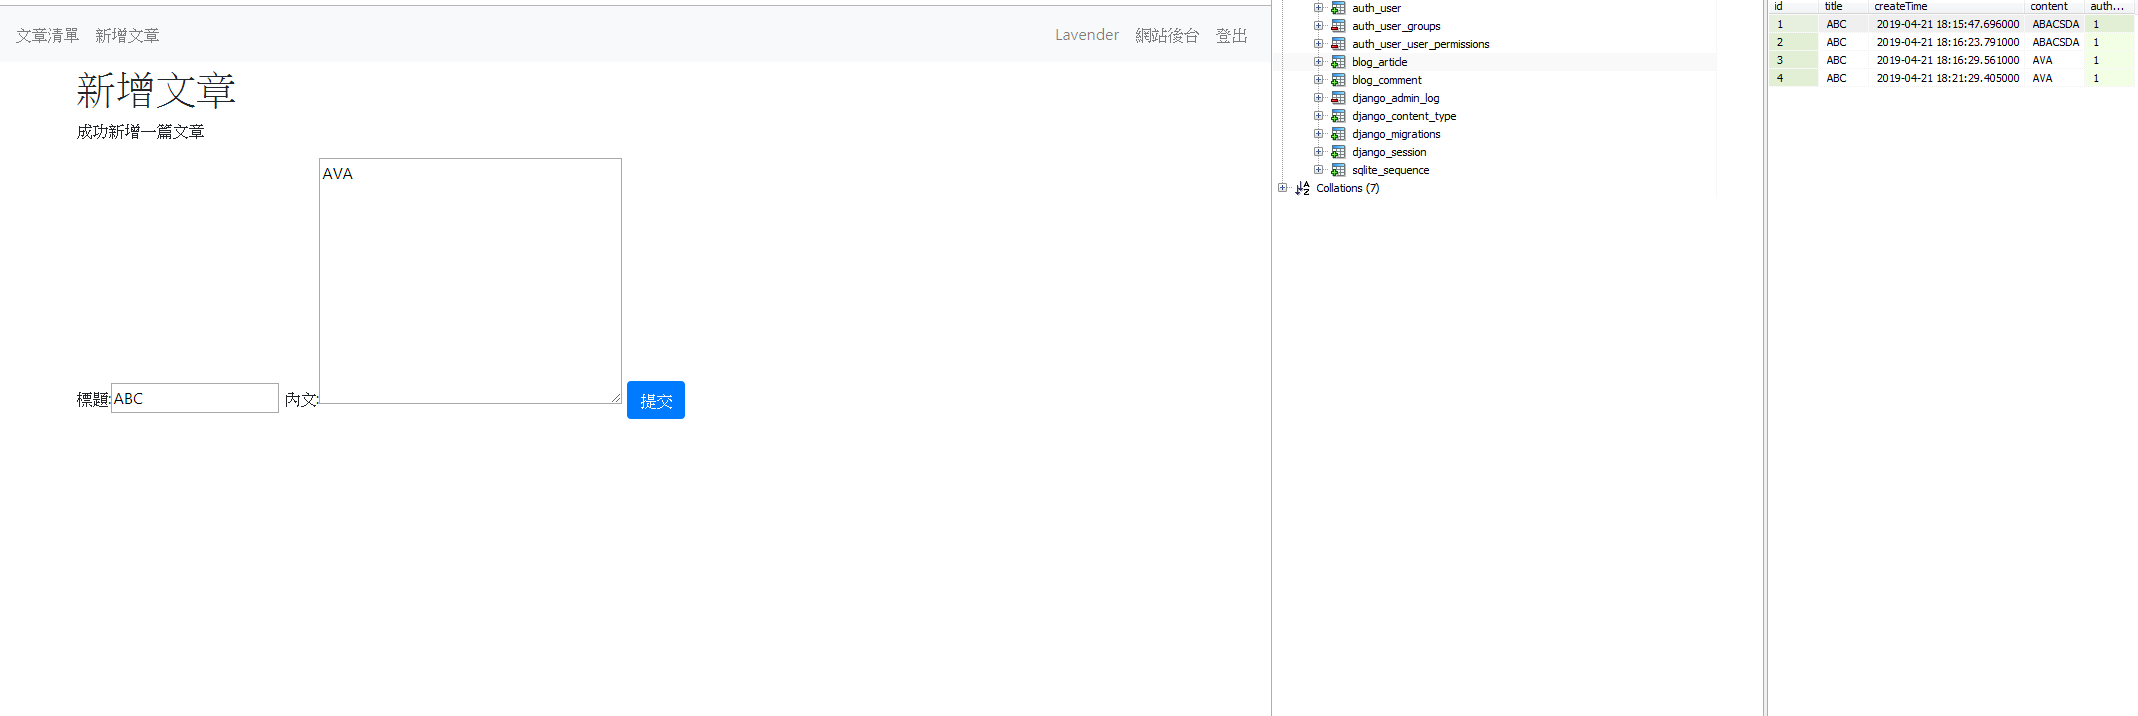

In [1]:
from IPython.display import Image
Image("images/P21.png")

不過，表單看起來醜醜的，但其實可以在 render 的時候依自己想處理 form 物件，render 出更漂亮的結果
或者用別人做好的來用，比方說
https://simpleisbetterthancomplex.com/tutorial/2018/08/13/how-to-use-bootstrap-4-forms-with-django.html

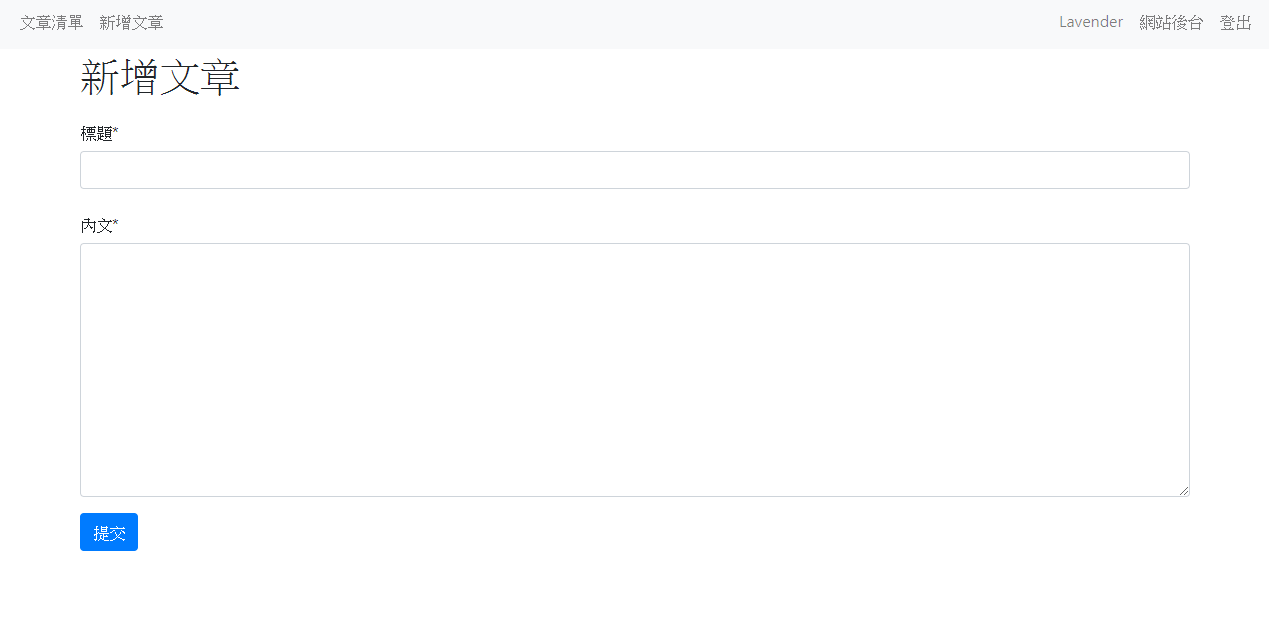

In [2]:
from IPython.display import Image
Image("images/P23.png")

二、clean form
==============
有些時候，我們想寫一些新的規則來驗證使用者提出的表單

比方說，我們想規定 Article title 只能 'ABC' 當開頭

In [ ]:
# blog/form.py
class ArticleForm(forms.ModelForm):

    class Meta:
        model = Article  # 這個 form 指定給 Article 這個 model 用
        fields = ['title', 'content'] # 在表單上只做出 Article 的兩個欄位
        labels = {
            'title': "標題",
            'content': "內文",
        }

    def clean_title(self): # clean_[想要的欄位](self)
        data = self.cleaned_data['title'] # 拿到表單資料
        if not data.startswith("ABC"):
            raise forms.ValidationError("文章開頭必須為 ABC")

        return data # 回傳 data

試試看表單

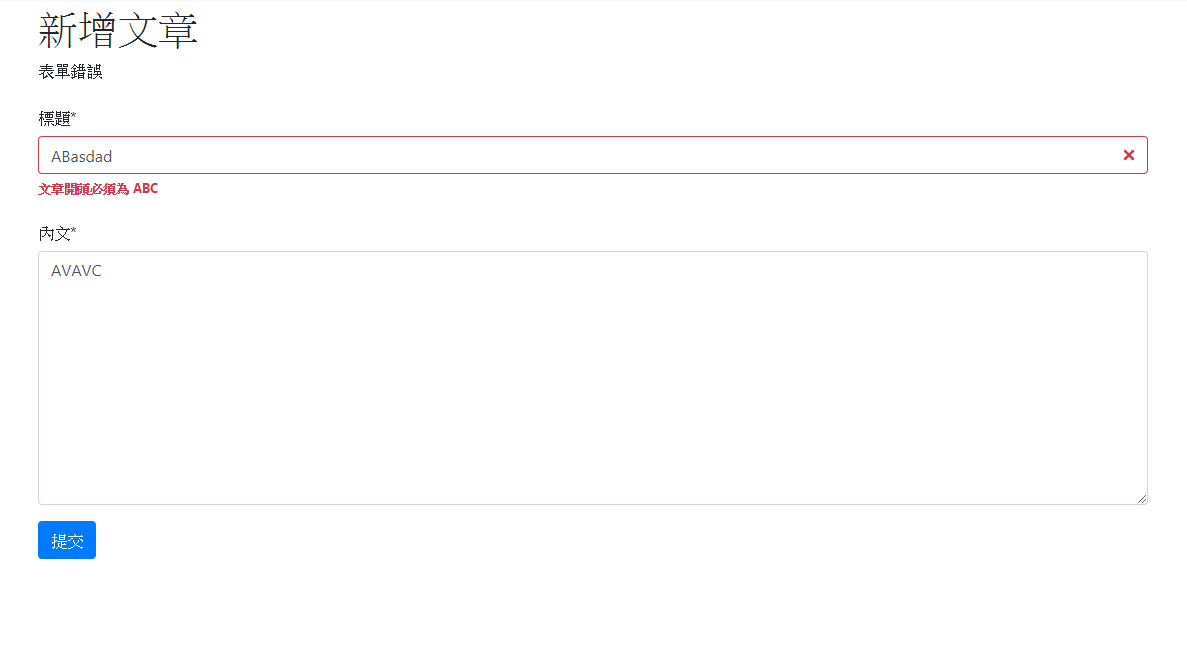

In [4]:
from IPython.display import Image
Image("images/P24.png")

另外還有個叫做 Validation 的功能，也是用來處理使用者表單提交時的資料清理

通常做網頁都需要做表單驗證的事情，而有了這些功能即可方便處理(避免資料不符規則或造成安全性問題)

詳情請看:
https://docs.djangoproject.com/en/2.2/ref/forms/validation/